In [78]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
1,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [5]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-LM.historical.day.gn']

In [6]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice("2000-01-01", "2014-12-31"))
dset

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, plev: 8, time: 5475, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(5475, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(54, 8, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    parent_experiment_id:      piControl
    parent_time_units:         days since 0421-01-01
    license:                   CMIP6 model data produced by NCC is licensed u...
    physics_index:             1
    version_id:                v20190815
    ...                        ...
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    source:                    NorESM2-LM (2017): \naerosol: OsloAero\natmos:...
    experiment_id:             historical
    realm:                     atmos
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

In [7]:
def compute_ivt(q,v,p):
    iv_ = np.zeros((q.shape[0],q.shape[2],q.shape[3]))
    pres_ = np.copy(p)
#    pres_[pres_>90000] = np.nan                                                                                                                                                                            
    pres_[pres_<25000] = np.nan
    pres_[~np.isnan(pres_)] = 1.0
    pres = np.where(pres_==1.0)
    pmax = np.max(pres[0])
    pmin = np.min(pres[0])
    dp_=np.zeros(len(pres[0]))
    for kk in range(len(dp_)):
        dp_[kk] = -p[pres[0][0]+kk+1]+p[pres[0][0]+kk]
    dp_=np.repeat(dp_[:,np.newaxis],q.shape[2],axis=1)
    dp_=np.repeat(dp_[:,:,np.newaxis],q.shape[3],axis=2)
    for i in range(q.shape[0]):
        p_ = pres_
        q_ = q[i,pres[0],:,:]
        v_ = v[i,pres[0],:,:]
        iv_[i,:,:] = -1/g*np.sum(q_*v_*dp_,axis=0)/(p[pmin]-p[pmax])
    return iv_


def compute_ivt1(q,v,p):
    g = 9.81
    pres_ = np.copy(p)
    pres_[pres_<25000] = np.nan
    pres_[~np.isnan(pres_)] = 1.0
    pres = np.where(pres_==1.0)
    pmax = np.max(pres[0])
    pmin = np.min(pres[0])
    dp_=np.zeros(len(pres[0]))
    for kk in range(len(dp_)):
        dp_[kk] = -p[pres[0][0]+kk+1]+p[pres[0][0]+kk]
    dp_=np.repeat(dp_[np.newaxis,:],q.shape[0],axis=0)
    dp_=np.repeat(dp_[:,:,np.newaxis],q.shape[2],axis=2)
    dp_=np.repeat(dp_[:,:,:,np.newaxis],q.shape[3],axis=3)
    p_ = pres_
    q_ = q[:,pres[0],:,:]
    v_ = v[:,pres[0],:,:]
    iv_ = -1/g*np.sum(q_*v_*dp_,axis=1)/(p[pmin]-p[pmax])
    return iv_

def to_nc(indata, lat_test, lon_test, tts, fln):
    nc = Dataset(fln, 'w')
    lat_dim = nc.createDimension('lat', indata.shape[1])
    lon_dim = nc.createDimension('lon', indata.shape[2])
    t_dim = nc.createDimension('time', indata.shape[0])
    lat_var = nc.createVariable('lat', np.float64, ('lat'))
    lat_var[:] = lat_test
    lon_var = nc.createVariable('lon', np.float64, ('lon'))
    lon_var[:] = lon_test
    tnd = nc.createVariable('ivt', np.float64, ('time','lat','lon'))
    tnd[:,:,:] = indata
    times = nc.createVariable('time', np.float64, ('time'))
    times[:] = tts
    nc.close()


In [8]:
vas = dset.va
hus = dset.hus
plev = dset.plev

In [59]:

lat_ = hus.lat
lon_ = hus.lon

ivt = compute_ivt1(hus,vas,plev)

#for yy in years:
#    hus_loc = hus.sel(time=slice(str(yy)+"-01-01", str(yy)+"-12-31"))
#    vas_loc = vas.sel(time=slice(str(yy)+"-01-01", str(yy)+"-12-31"))
#    tts_loc = hus_loc.time
#    ivt = compute_ivt(hus_loc,vas_loc,plev)
    #to_nc(ivt,lat_,lon_,range(len(tts_loc)),'ivt'+str(yy)+'.nc')
    #print('ivt'+str(yy)+'.nc')

(5475, 5, 96, 144)


In [60]:
print(ivt.shape)
ivt = xr.where(ivt<0,ivt*0,ivt,True)
print(ivt)
q98 = np.percentile(ivt,98,axis=0)
print(q98)

(5475, 96, 144)
<xarray.DataArray (time: 5475, lat: 96, lon: 144)>
dask.array<where, shape=(5475, 96, 144), dtype=float64, chunksize=(143, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
[[0.00030875 0.00030616 0.00030335 ... 0.00031853 0.00031613 0.00031351]
 [0.000329   0.000328   0.00032516 ... 0.00033798 0.00033268 0.00033014]
 [0.00043504 0.00042134 0.00040642 ... 0.00045736 0.00044802 0.00044498]
 ...
 [0.00157663 0.00158242 0.00159106 ... 0.00162295 0.00160469 0.00157679]
 [0.00161527 0.00162449 0.00158218 ... 0.00166191 0.00163377 0.00163466]
 [0.00156428 0.00155126 0.00154991 ... 0.00159327 0.00158394 0.00155816]]


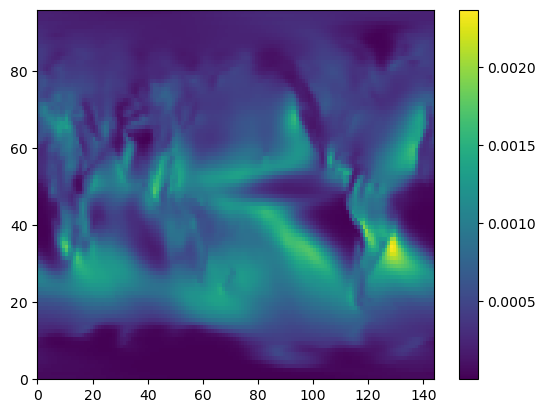

In [61]:
plt.pcolormesh(ivt.mean(dim='time'))
plt.colorbar()
plt.show()

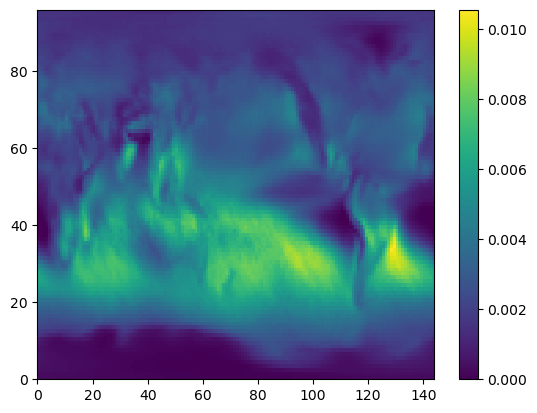

In [62]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()

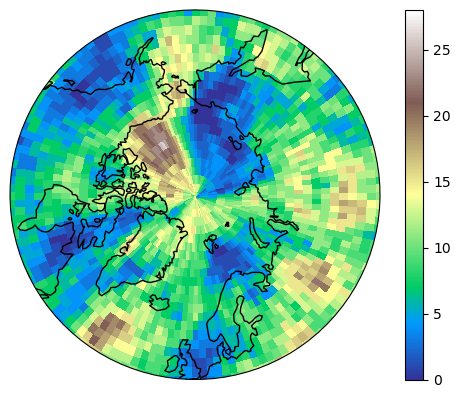

In [84]:
excess14 = ivt.sel(time=slice("2014-01-01", "2014-12-31"))
excess14 = excess14-q98
excess14 = xr.where(excess14>0,1,excess*0)

pole='Arctic'

if pole=='Antarctic':
    ax1 = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
    ax1.set_extent([-180,180,-50,-90], ccrs.PlateCarree())
else:
    ax1 = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
    ax1.set_extent([-180,180,50,90], ccrs.PlateCarree())

ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
m = ax1.pcolormesh(lon_,lat_,excess14.sum(dim='time'),transform=ccrs.PlateCarree(),cmap='terrain')

#plt.pcolormesh(excess.sum(dim='time'))
plt.colorbar(m)
plt.show()

In [106]:
pole='Arctic'

from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation

fig = plt.figure()
vertical_array = excess14
    
def animate(i):
    ax1 = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
    ax1.set_extent([-180,180,50,90], ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(0.5,0.5,0.5,0))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cax1 = ax1.pcolormesh(lon_,lat_,vertical_array[0,:,:],transform=ccrs.PlateCarree(),cmap='Blues',vmin=0,vmax=1)
    cbar = plt.colorbar(cax1)
    cax1.set_array(vertical_array[i,:,:])
    ax1.set_title(vertical_array[i,:,:].time.values.astype('datetime64[D]'))

anim = FuncAnimation(fig, animate, frames=100, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

<IPython.core.display.Javascript object>

ValueError: Collections can only map rank 1 arrays. You likely want to call with a flattened array using collection.set_array(A.ravel()) instead.

In [101]:
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)
def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line
anim = FuncAnimation(fig, animate, frames=100, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()  

<IPython.core.display.Javascript object>